## Sale forecasting with LSTM auto encoder and LSTM model

### Importing the libraries

In [1]:
import datalabframework as dlf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
from pyspark.sql import Window
from pyspark.sql import functions as F

### Loading the fact table and the dataset

In [3]:
dlf.project.load()

SPARK_DIST_CLASSPATH not defined and spark installed without hadoop
define SPARK_DIST_CLASSPATH in $SPARK_HOME/conf/spark-env.sh as follows:

   export SPARK_DIST_CLASSPATH=$(hadoop classpath)

for more info refer to: https://spark.apache.org/docs/latest/hadoop-provided.html

ERROR:dlf:Hadoop is not detected. Some packages/jars might not work correctly.


In [4]:
engine = dlf.project.engine()

In [5]:
df = engine.load("fact_table")

INFO:dlf:{'md': {'hash': '0x73be70f413b04324', 'url': 'hdfs://bigdata-m.teko.vn:18020/teko/prod/etl/fact/fact_table', 'service': 'hdfs', 'format': 'parquet', 'host': 'bigdata-m.teko.vn', 'port': 18020, 'driver': None, 'database': None, 'username': None, 'password': None, 'resource_path': 'fact_table', 'provider_path': '/teko/prod/etl/fact', 'provider_alias': 'fact', 'resource_alias': 'fact_table', 'cache': None, 'date_column': None, 'date_start': None, 'date_end': None, 'date_window': None, 'date_partition': None, 'update_column': None, 'hash_column': None, 'state_column': None, 'options': {}, 'mapping': {}}, 'mode': None, 'records': 6091832, 'columns': 126, 'time': 10.576411547139287, 'time_core': 6.590524902567267, 'time_prep': 3.985885463654995}


In [6]:
transactions_df = df.select('transaction_date', 'sku_id', 'sku_name', 'cat_name', 'cat_root_name', 'quantity', 'discount', 'unit_price', 'brand_name') \
.filter((df.doc_type == 'PTX') | (df.doc_type == 'HDF'))

In [7]:
laptop_transactions_df = transactions_df.select('transaction_date', 'quantity') \
.filter((transactions_df.cat_root_name == 'laptop') & (transactions_df.transaction_date <= '2019-04-30')) \
.groupby('transaction_date') \
.agg(F.sum('quantity').alias('daily_quantity')) \
.orderBy('transaction_date').toPandas()

In [8]:
laptop_transactions_df.transaction_date = pd.to_datetime(laptop_transactions_df.transaction_date)
laptop_transactions_df.daily_quantity = pd.to_numeric(laptop_transactions_df.daily_quantity)

In [9]:
laptop_transactions_df.head()

,transaction_date,daily_quantity
0,2017-01-01,86.0
1,2017-01-02,105.0
2,2017-01-03,102.0
3,2017-01-04,113.0
4,2017-01-05,97.0


In [10]:
laptop_transactions_df.dtypes

transaction_date    datetime64[ns]
daily_quantity             float64
dtype: object

### Handling missing data

In [11]:
from datetime import date, timedelta
start_date = date(2017, 1, 1)
end_date = date(2019, 4, 30)
n_days = (end_date - start_date).days + 1

In [12]:
ordered_index = []
transaction_date_list = laptop_transactions_df.transaction_date.tolist()
l = [day.strftime('%Y-%m-%d') for day in transaction_date_list]

for i in range (n_days):
    day = (start_date + timedelta(i)).strftime('%Y-%m-%d')
    ordered_index.append(day)

    if (day not in l):
        previous_day = (start_date + timedelta(i - 1)).strftime('%Y-%m-%d')
        print(day)
        # print(int(laptop_transactions_df[laptop_transactions_df.transaction_date == previous_day].daily_quantity.values[0]))
        # previous_week_day = [(start_date + timedelta(j)).strftime('%Y-%m-%d') for j in range (i - 7, i)]
        # laptop_total_sale[day] = laptop_total_sale[previous_day]
        # laptop_total_sale[day] = laptop_total_sale[previous_week_day].mean().round()
        
        row = pd.DataFrame({'transaction_date': day, 'daily_quantity': None}, index = [0])
        laptop_transactions_df = pd.concat([laptop_transactions_df, row]).reset_index(drop = True)

2017-01-26
2017-01-27
2017-01-28
2017-01-29
2017-01-30
2017-01-31
2017-02-01
2018-02-14
2018-02-15
2018-02-16
2018-02-17
2018-02-18
2018-02-19
2018-02-20
2019-02-03
2019-02-04
2019-02-05
2019-02-06
2019-02-07
2019-02-08
2019-02-09


In [13]:
laptop_transactions_df.transaction_date = pd.to_datetime(laptop_transactions_df.transaction_date)

In [14]:
laptop_transactions_df.dtypes

transaction_date    datetime64[ns]
daily_quantity             float64
dtype: object

In [15]:
laptop_transactions_df.tail(10)

,transaction_date,daily_quantity
840,2018-02-18,NaN
841,2018-02-19,NaN
842,2018-02-20,NaN
843,2019-02-03,NaN
844,2019-02-04,NaN
845,2019-02-05,NaN
846,2019-02-06,NaN
847,2019-02-07,NaN
848,2019-02-08,NaN
849,2019-02-09,NaN


In [16]:
laptop_transactions_df = laptop_transactions_df.sort_values(by = ['transaction_date']).reset_index(drop = True)

In [17]:
laptop_transactions_df.tail(10)

,transaction_date,daily_quantity
840,2019-04-21,206.0
841,2019-04-22,191.0
842,2019-04-23,167.0
843,2019-04-24,223.0
844,2019-04-25,139.0
845,2019-04-26,176.0
846,2019-04-27,167.0
847,2019-04-28,154.0
848,2019-04-29,151.0
849,2019-04-30,126.0


In [18]:
laptop_transactions_df_fill = laptop_transactions_df.copy()
# laptop_transactions_df_fill = pd.Series(laptop_transactions_df.daily_quantity.values, index = laptop_transactions_df.transaction_date)
laptop_transactions_df_fill.daily_quantity.interpolate(method = 'slinear', inplace = True)

In [19]:
laptop_transactions_df_fill.dtypes

transaction_date    datetime64[ns]
daily_quantity             float64
dtype: object

### Visualising total data

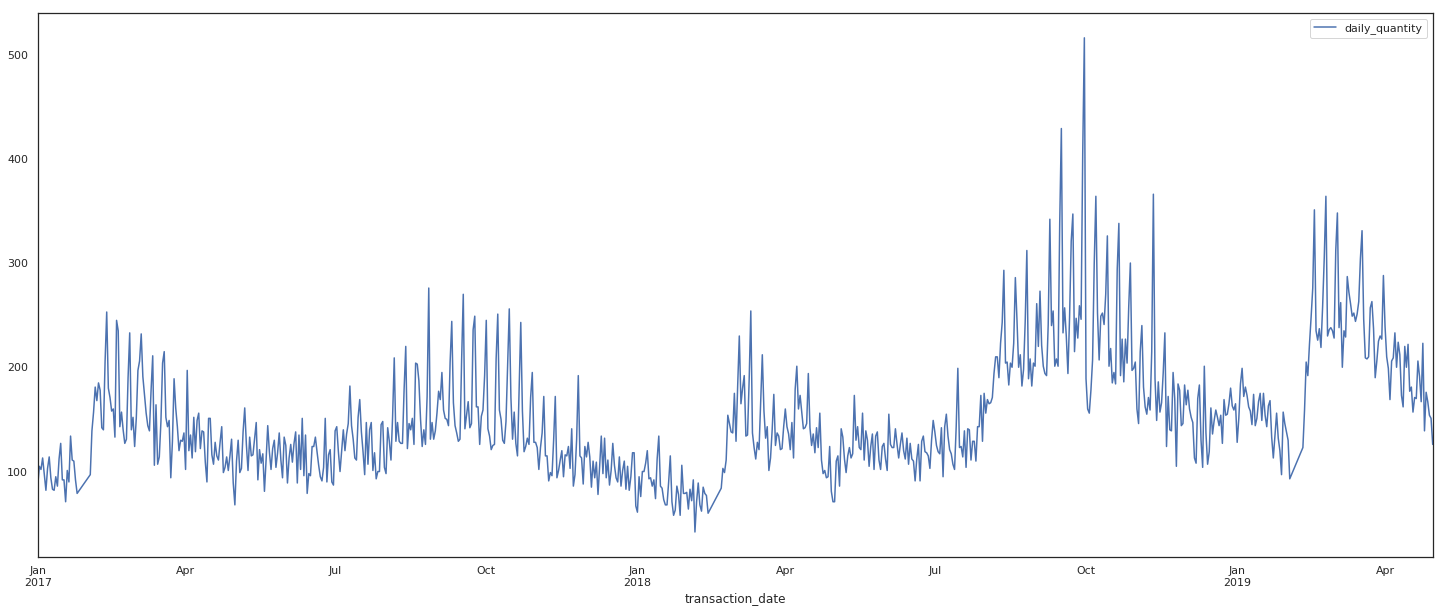

In [20]:
sns.set_style("white")
laptop_transactions_df_fill.plot(x = 'transaction_date', y = 'daily_quantity', figsize = (25, 10));

### Spliting data into training and test set

In [21]:
training_set = laptop_transactions_df_fill.iloc[:-90].daily_quantity.values
test_set = laptop_transactions_df_fill.iloc[-90:].daily_quantity.values

### Feature scaling

In [22]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0, 1))

training_set_scaled = sc.fit_transform(training_set.reshape(-1, 1))

In [23]:
training_set_scaled.shape

(760, 1)

### Create data structure with several timesteps

In [24]:
n_timesteps = 7
n_training_samples = training_set_scaled.shape[0]

X_train = []
y_train = []

for i in range (n_timesteps, n_training_samples):
    X_train.append(training_set_scaled[i - n_timesteps: i])
    y_train.append(training_set_scaled[i])
    
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [25]:
X_train.shape

(753, 7, 1)

### Building a LSTM encoder-decoder for time series data

In [26]:
from keras import Sequential
from keras.layers import LSTM, Dense, Dropout, TimeDistributed
from keras import regularizers

Using TensorFlow backend.


In [31]:
model = Sequential()

model.add(LSTM(units = 3, activation = 'relu', return_sequences = True, input_shape = (X_train.shape[1], 1), kernel_regularizer = regularizers.l1_l2(l1=0.00, l2=0.00)))
# model.add(LSTM(units = 2, activation = 'relu', return_sequences = True))
# model.add(LSTM(units = 3, activation = 'relu', return_sequences = True))
model.add(TimeDistributed(Dense(1)))

In [32]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 7, 3)              60        
_________________________________________________________________
time_distributed_2 (TimeDist (None, 7, 1)              4         
Total params: 64
Trainable params: 64
Non-trainable params: 0
_________________________________________________________________


In [33]:
model.compile(optimizer = 'adam', loss = 'mse')

In [34]:
model.fit(X_train, X_train, epochs = 100, batch_size = 32)

Epoch 1/100
753/753 [==============================] - 1s 1ms/step - loss: 0.0549
Epoch 2/100
753/753 [==============================] - 0s 389us/step - loss: 0.0431
Epoch 3/100
753/753 [==============================] - 0s 399us/step - loss: 0.0315
Epoch 4/100
753/753 [==============================] - 0s 392us/step - loss: 0.0221
Epoch 5/100
753/753 [==============================] - 0s 378us/step - loss: 0.0161
Epoch 6/100
753/753 [==============================] - 0s 384us/step - loss: 0.0136
Epoch 7/100
753/753 [==============================] - 0s 379us/step - loss: 0.0131
Epoch 8/100
753/753 [==============================] - 0s 385us/step - loss: 0.0127
Epoch 9/100
753/753 [==============================] - 0s 385us/step - loss: 0.0124
Epoch 10/100
753/753 [==============================] - 0s 401us/step - loss: 0.0121
Epoch 11/100
753/753 [==============================] - 0s 392us/step - loss: 0.0117
Epoch 12/100
753/753 [==============================] - 0s 393us/step - loss

In [35]:
y_hat = model.predict(X_train)
y_hat.shape

(753, 7, 1)

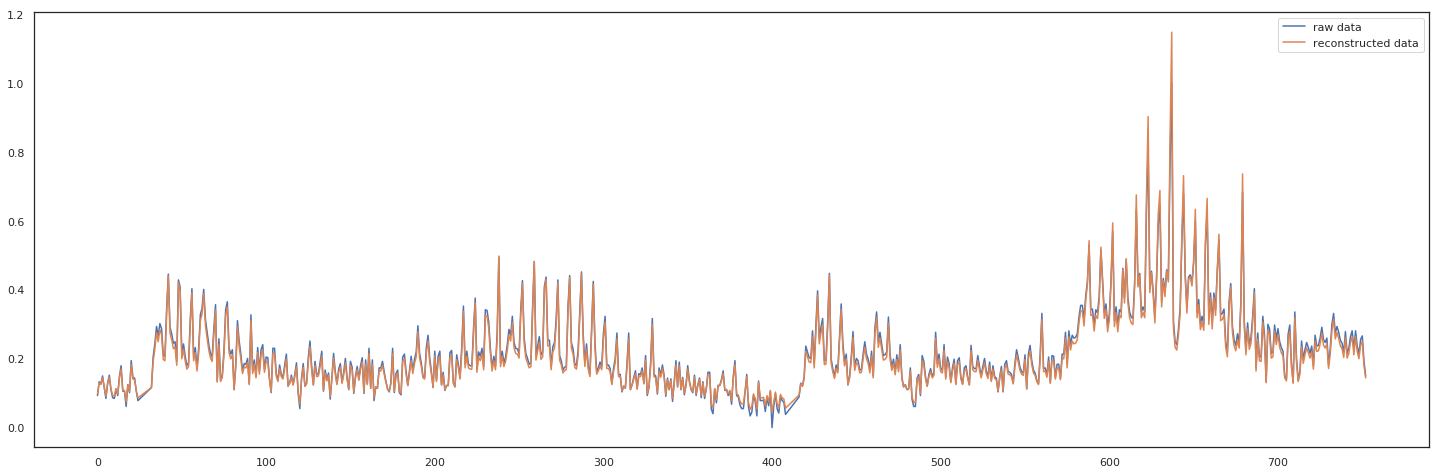

In [36]:
fig, ax = plt.subplots(figsize = (25, 8))
ax.plot(X_train[:, 0, 0], label = 'raw data')
ax.plot(y_hat[:, 0, 0], label = 'reconstructed data')
ax.legend()
plt.show();

In [37]:
# model.save('encoder_decoder_laptop_asus.h5')

### Building LSTM encoder for sale data

In [38]:
from keras.models import Model

In [39]:
encoder_model = Model(inputs = model.inputs, outputs = model.layers[0].output)

In [40]:
y_encoded = encoder_model.predict(X_train)

In [41]:
y_encoded.shape

(753, 7, 3)

In [42]:
X_train_new = np.append(X_train, y_encoded, axis = 2)

In [43]:
X_train_new.shape

(753, 7, 4)

### New test set

In [44]:
inputs = laptop_transactions_df_fill.iloc[len(laptop_transactions_df) - len(test_set) - n_timesteps:].daily_quantity.values.reshape((-1, 1))
inputs = sc.transform(inputs)

X_test = []
y_test = []

n_input_samples = inputs.shape[0]

for i in range(n_timesteps, n_input_samples):
    X_test.append(inputs[i - n_timesteps: i, 0])
    y_test.append(inputs[i, 0])

X_test, y_test = np.array(X_test), np.array(y_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [45]:
X_test.shape

(90, 7, 1)

In [46]:
X_test_feature_extraction = encoder_model.predict(X_test)

In [47]:
X_test_new = np.append(X_test, X_test_feature_extraction, axis = 2)

In [48]:
X_test_new.shape

(90, 7, 4)

### RNN for forecasting

In [83]:
from keras import regularizers
# Initialising the RNN
regressor = Sequential()

regressor.add(LSTM(units = 7, activation='relu', kernel_regularizer = regularizers.l1_l2(l1=0.00, l2=0.00), input_shape = (X_train_new.shape[1], X_train_new.shape[2])))
# regressor.add(Dropout(0.1))

# regressor.add(LSTM(units = 4, activation='relu'))
#regressor.add(Dropout(0.2))

regressor.add(Dense(units = 1))

In [84]:
regressor.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 7)                 336       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 8         
Total params: 344
Trainable params: 344
Non-trainable params: 0
_________________________________________________________________


In [85]:
regressor.compile(optimizer = 'adam', loss = 'mse')

In [86]:
from keras import callbacks
class myCallback(callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_loss') < 0.0005):
            print("Cancelling training when val_loss is less than 0.0005")
            self.model.stop_training = True

callbacks = myCallback()

In [87]:
training_history = regressor.fit(X_train_new, y_train, epochs = 200, batch_size = 32, validation_data = (X_test_new, y_test), callbacks = [callbacks])

Train on 753 samples, validate on 90 samples
Epoch 1/200
753/753 [==============================] - 1s 2ms/step - loss: 0.0434 - val_loss: 0.0833
Epoch 2/200
753/753 [==============================] - 0s 400us/step - loss: 0.0266 - val_loss: 0.0505
Epoch 3/200
753/753 [==============================] - 0s 379us/step - loss: 0.0129 - val_loss: 0.0175
Epoch 4/200
753/753 [==============================] - 0s 412us/step - loss: 0.0070 - val_loss: 0.0083
Epoch 5/200
753/753 [==============================] - 0s 400us/step - loss: 0.0066 - val_loss: 0.0092
Epoch 6/200
753/753 [==============================] - 0s 406us/step - loss: 0.0063 - val_loss: 0.0079
Epoch 7/200
753/753 [==============================] - 0s 413us/step - loss: 0.0062 - val_loss: 0.0079
Epoch 8/200
753/753 [==============================] - 0s 405us/step - loss: 0.0060 - val_loss: 0.0074
Epoch 9/200
753/753 [==============================] - 0s 411us/step - loss: 0.0059 - val_loss: 0.0072
Epoch 10/200
753/753 [========

In [56]:
# regressor.save('training_model_1.h5')

### Loss

In [88]:
loss = training_history.history['loss']
val_loss = training_history.history['val_loss']

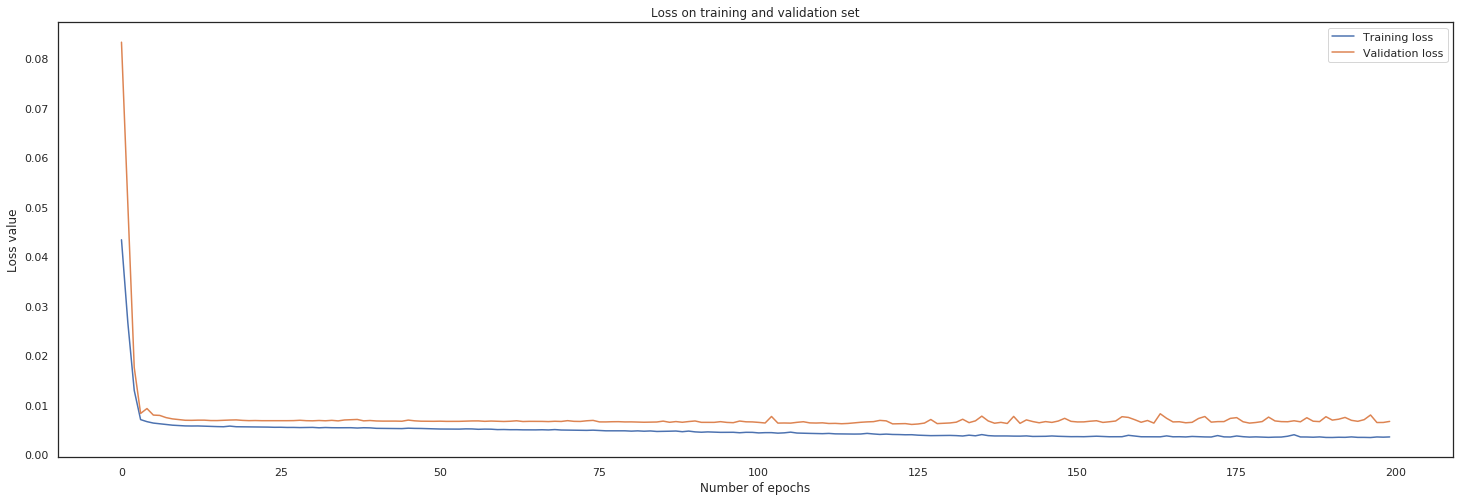

In [89]:
sns.set_style('white')
fig, ax = plt.subplots(figsize = (25, 8))

ax.plot(loss, label = 'Training loss')
ax.plot(val_loss, label = 'Validation loss')
ax.set_title('Loss on training and validation set')
ax.set_xlabel('Number of epochs')
ax.set_ylabel('Loss value')
ax.legend()

plt.show();

### Making prediction

In [90]:
real_sale_number = test_set[:]

In [91]:
real_sale_number.shape

(90,)

In [92]:
real_sale_number = sc.inverse_transform(y_test.reshape(-1, 1))
real_sale_number = np.reshape(real_sale_number, (real_sale_number.shape[0],))

In [93]:
y_pred = regressor.predict(X_test_new)
predicted_sale_number = sc.inverse_transform(y_pred)

In [94]:
predicted_sale_number = np.reshape(predicted_sale_number, (predicted_sale_number.shape[0],))

In [95]:
predicted_sale_number.shape

(90,)

### Visualisation of prediction

(0, 377.55)

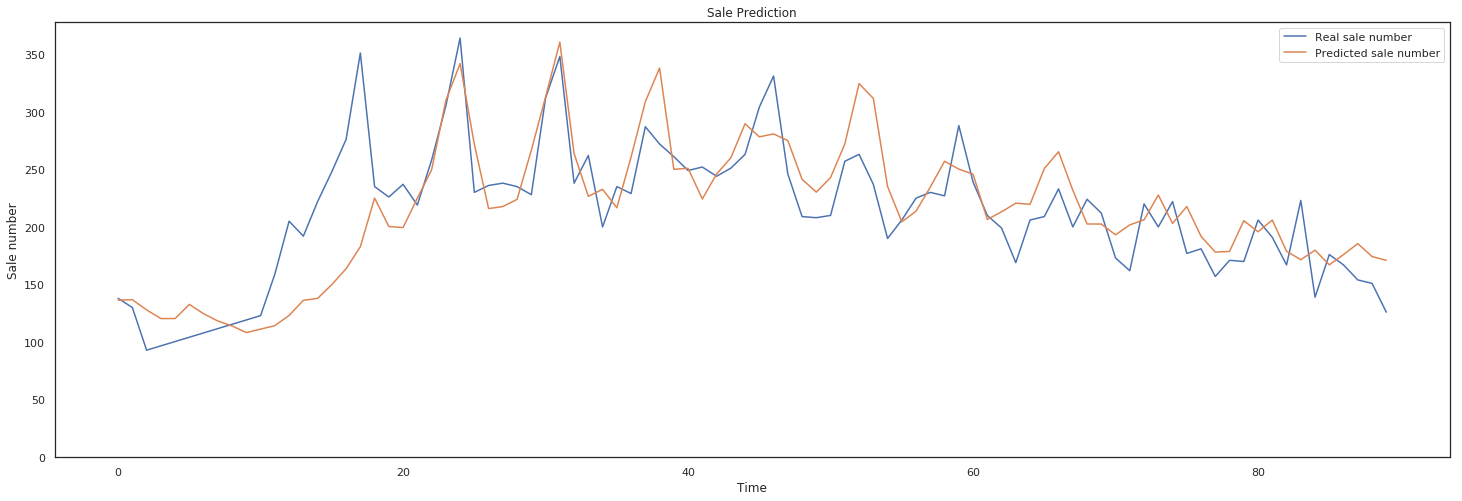

In [96]:
sns.set_style('white')
fig, ax = plt.subplots(figsize = (25, 8))

ax.plot(real_sale_number, label = 'Real sale number')
ax.plot(predicted_sale_number, label = 'Predicted sale number')
ax.set_title('Sale Prediction')
ax.set_xlabel('Time')
ax.set_ylabel('Sale number')
ax.legend()
ax.set_ylim([0, None])

# plt.savefig('predict_demo.png');

### Error

In [97]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae, mse = mean_absolute_error(real_sale_number, predicted_sale_number), mean_squared_error(real_sale_number, predicted_sale_number)
print("Mean absolute error:", mae)
print("Mean squared error:", mse)

Mean absolute error: 28.451315307617186
Mean squared error: 1494.0477608458204


In [98]:
def mean_absolute_percentage_error(y_true, y_pred):
    total = 0
    count = 0
    for i in range (len(y_true)):
        if y_true[i] != 0:
            total += abs((y_true[i] - y_pred[i]) / y_true[i])
            count += 1
    return total / count * 100

In [99]:
mape = mean_absolute_percentage_error(real_sale_number, predicted_sale_number)
print("Mean absolute percentage error:", mape)

Mean absolute percentage error: 13.843220033849683


### Visualization for demo

In [100]:
inputs = laptop_transactions_df_fill.daily_quantity.values.reshape((-1, 1))
inputs = sc.transform(inputs)

X_demo = []
y_demo = []

n_input_samples = inputs.shape[0]

for i in range(n_timesteps, n_input_samples):
    X_demo.append(inputs[i - n_timesteps: i, 0])
    y_demo.append(inputs[i, 0])

X_demo, y_demo = np.array(X_demo), np.array(y_demo)

X_demo = np.reshape(X_demo, (X_demo.shape[0], X_demo.shape[1], 1))

In [101]:
X_demo_feature_extraction = encoder_model.predict(X_demo)

In [102]:
X_demo_new = np.append(X_demo, X_demo_feature_extraction, axis = 2)

In [103]:
X_demo_new.shape

(843, 7, 4)

In [104]:
real_sale_number = sc.inverse_transform(y_demo.reshape(-1, 1))
real_sale_number = np.reshape(real_sale_number, (real_sale_number.shape[0],))

In [105]:
y_pred_demo = regressor.predict(X_demo_new)
predicted_sale_number = sc.inverse_transform(y_pred_demo)

In [106]:
predicted_sale_number = np.reshape(predicted_sale_number, (predicted_sale_number.shape[0],))

In [107]:
predicted_sale_number.shape

(843,)

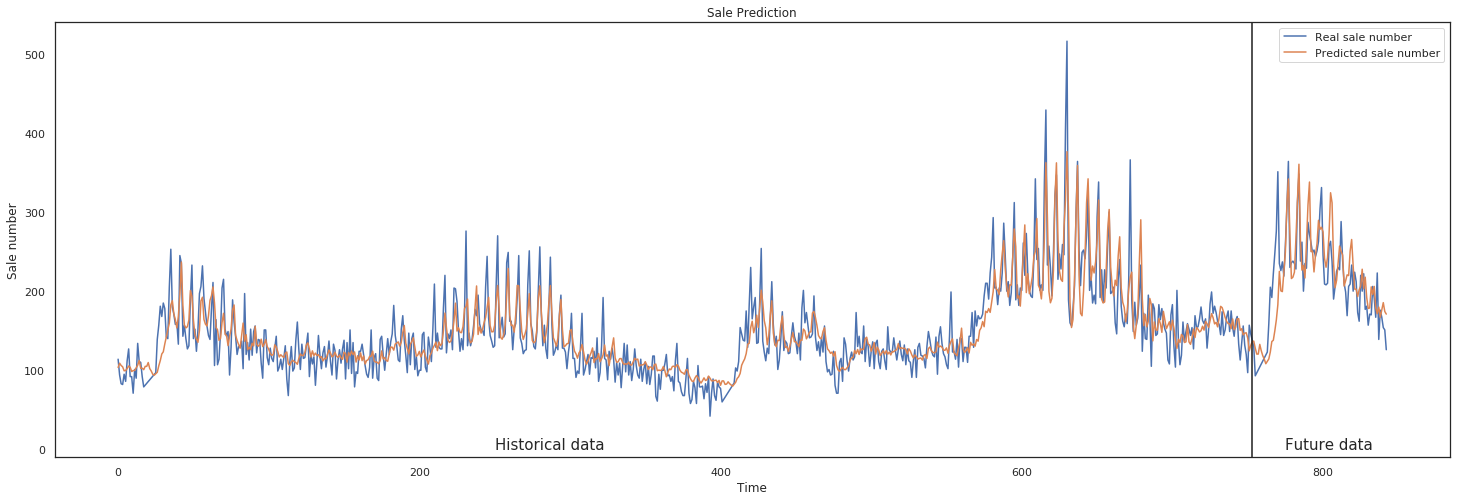

In [108]:
sns.set_style('white')
fig, ax = plt.subplots(figsize = (25, 8))

ax.plot(real_sale_number, label = 'Real sale number')
ax.plot(predicted_sale_number, label = 'Predicted sale number')
ax.set_title('Sale Prediction')
ax.set_xlabel('Time')
ax.set_ylabel('Sale number')
ax.legend()
ax.axvline(x = 843 - 90, color = 'k')
ax.text(250, 0, 'Historical data', fontsize = 15)
ax.text(775, 0, 'Future data', fontsize = 15)
ax.set_ylim([-10, None])
plt.show();
# plt.savefig('predict_demo.png');

In [109]:
real_sale_number.shape

(843,)

In [110]:
predicted_sale_number.shape

(843,)

In [111]:
demo_df = pd.DataFrame(np.append(real_sale_number.reshape(-1, 1), predicted_sale_number.reshape(-1, 1), axis = 1), columns = ['real_sale_number', 'predicted_sale_number'])

In [112]:
demo_df['transaction_date'] = ordered_index[7:]
demo_df.transaction_date = pd.to_datetime(demo_df.transaction_date)

In [113]:
demo_df.head()

,real_sale_number,predicted_sale_number,transaction_date
0,114.0,103.573517,2017-01-08
1,94.0,108.904564,2017-01-09
2,83.0,106.051682,2017-01-10
3,82.0,104.400131,2017-01-11
4,95.0,99.369400,2017-01-12


In [114]:
demo_df.dtypes

real_sale_number                float64
predicted_sale_number           float64
transaction_date         datetime64[ns]
dtype: object

(-10, 539.7)

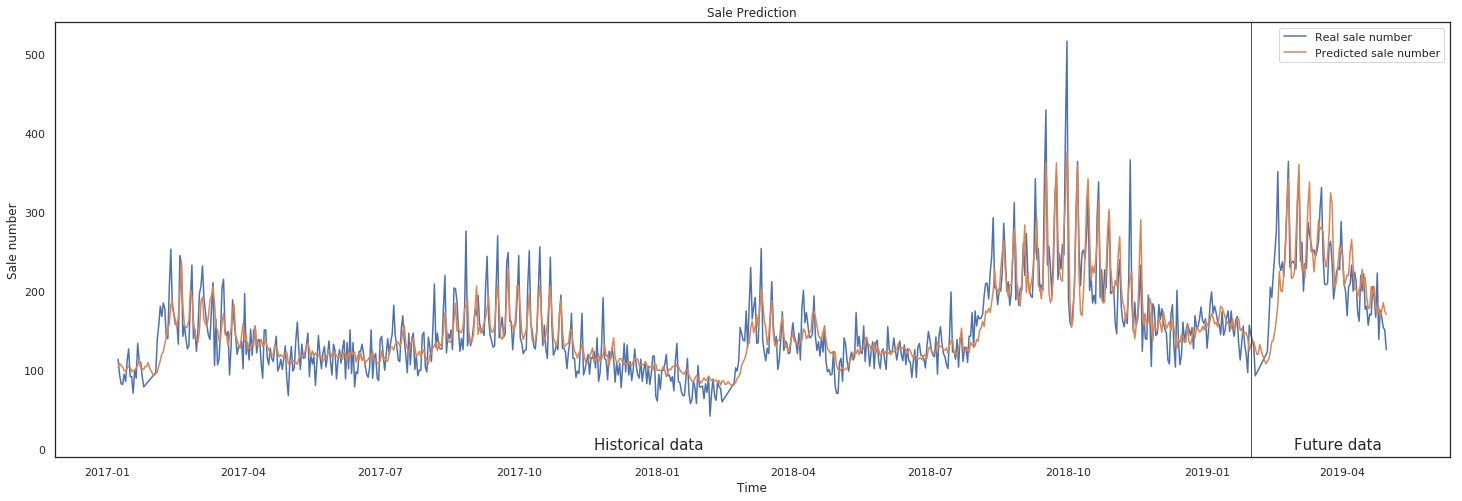

In [115]:
sns.set_style('white')
fig, ax = plt.subplots(figsize = (25, 8))

# demo_df.plot(x = 'transaction_date', y = ['real_sale_number', 'predicte?'])

ax.plot(demo_df.transaction_date.values, demo_df.real_sale_number, label = 'Real sale number')
ax.plot(demo_df.transaction_date.values, demo_df.predicted_sale_number, label = 'Predicted sale number')
ax.set_title('Sale Prediction')
ax.set_xlabel('Time')
ax.set_ylabel('Sale number')
ax.legend()
ax.axvline(x = '2019-01-30', color = 'k', linewidth = 0.75)
ax.text('2017-11-20', 0, 'Historical data', fontsize = 15)
ax.text('2019-02-28', 0, 'Future data', fontsize = 15)
ax.set_ylim([-10, None])

# plt.savefig('predict_demo_3.png');

In [116]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae, mse = mean_absolute_error(real_sale_number, predicted_sale_number), mean_squared_error(real_sale_number, predicted_sale_number)
print("Mean absolute error:", mae)
print("Mean squared error:", mse)

Mean absolute error: 21.3349958535191
Mean squared error: 834.4970114208575
